In [1]:
import scipy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import sklearn

In [2]:
from ppg.common import config
from ppg.common.utils import load_data
from ppg.enums import DataColumn, WavelengthIndex

In [11]:
ts1 = load_data(config.DATA_DIR / 'ppg_curve_0.nc')
ts2 = load_data(config.DATA_DIR / 'ppg_curve_1.nc')

# df = pd.read_parquet('../../data/ext.parquet')
# ppg_data = df.values
# df.columns = [c.name for c  in WavelengthIndex]

In [12]:
# sampling frequency
Fs = 100
Tstep = 1 / Fs

# number of samples
N = len(ts1[DataColumn.TIME])
Fstep = Fs / N

FILTER_ORDER = 5

In [14]:
TS1_DURATION = max(ts1[DataColumn.TIME][:])
TS2_DURATION = max(ts2[DataColumn.TIME][:])

TS1_BEGIN = datetime.fromisoformat(ts1[DataColumn.PPG_CURVE].meas_datetime)
TS2_BEGIN = datetime.fromisoformat(ts2[DataColumn.PPG_CURVE].meas_datetime)
GAP_DURATION = (TS1_BEGIN - TS2_BEGIN - timedelta(seconds=TS2_DURATION)).seconds

In [15]:
(TS1_BEGIN - TS2_BEGIN - timedelta(seconds=TS2_DURATION)).total_seconds() * 1001

45143.098

In [16]:
# GAP_DURATION = 5

GAP_DURATION

45

In [123]:
from ppg.processing import Processor
from sklearn import preprocessing

class MinMaxScaler(Processor):
    """
    Perform Min-Max scaling on the data. It transforms features by scaling each feature to a given range.
    This range can be specified by the user, and default is 0 to 1.
    """

    def __init__(self, scale_min=0, scale_max=1):
        self.scale_min = scale_min
        self.scale_max = scale_max

    def process(self, data: np.array) -> np.array:

        assert data.shape[0] == len(WavelengthIndex), 'Invalid data format! Expecting masked_array with 3 channels.'

        for i in range(data.shape[0]):
            data_min = np.min(data[i])
            data_max = np.max(data[i])

            if (data_max - data_min) != 0:
                data[i, :] = (data[i] - data_min) / (data_max - data_min) * (self.scale_max - self.scale_min) + self.scale_min
            else:
                data[i, :] = data[i] - data_min

        return data

In [124]:
from ppg.processing.normalization import ZscoreNormalization
from ppg.processing.filter import BandPassPaddingFilter
from ppg.processing.missing_values import PolynomialInterpolation
from ppg.processing import Pipeline

pipeline = Pipeline([
    PolynomialInterpolation(),
    # ZscoreNormalization(),
    BandPassPaddingFilter(order=config.DEFAULT_FILTER_ORDER,
                          sampling_frequency=Fs,
                          cutoff_frequencies=(0.1, 5),
                          padding_size=Fs * config.FILTER_PADDING_MULTIPLIER),
    MinMaxScaler()
])

In [125]:
max(ts1[DataColumn.PPG_CURVE][:][0])

62258.0

In [126]:
ts1_data = pipeline.process(ts1[DataColumn.PPG_CURVE][:])[:, -9000:]
ts2_data = pipeline.process(ts2[DataColumn.PPG_CURVE][:])[:, :9000]

# ts1_data = ts1_data[:]

data_before_gap = ts1_data[WavelengthIndex.RED]
data_after_gap = ts2_data[WavelengthIndex.RED]

gap_data = np.empty((3, GAP_DURATION * Fs))
gap_data[:] = np.nan

In [127]:
ppg_data = np.concatenate((ts1_data, gap_data, ts2_data), axis=1)

time_steps = np.arange(0, ppg_data.shape[1]/Fs, 1/Fs)

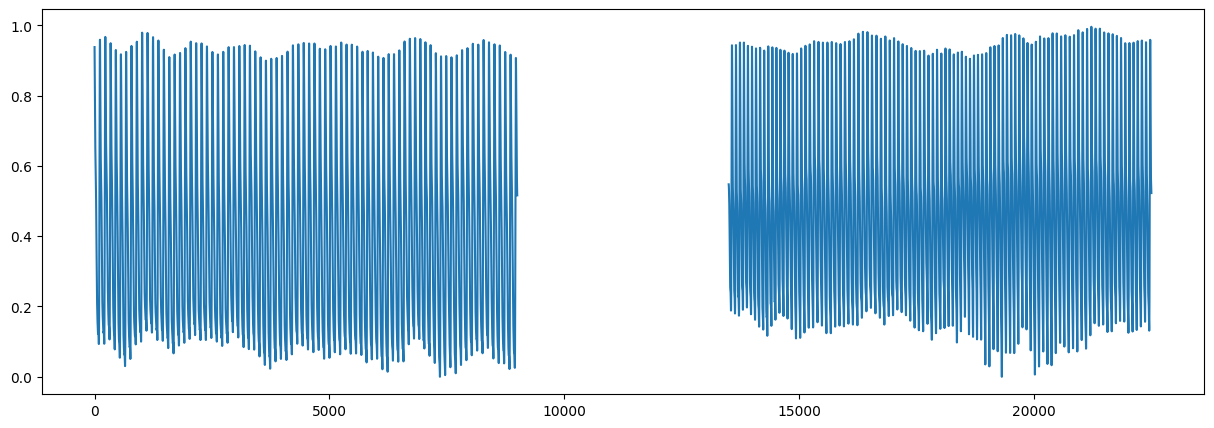

In [128]:
plt.figure(figsize=(15,5))
plt.plot(ppg_data[0])

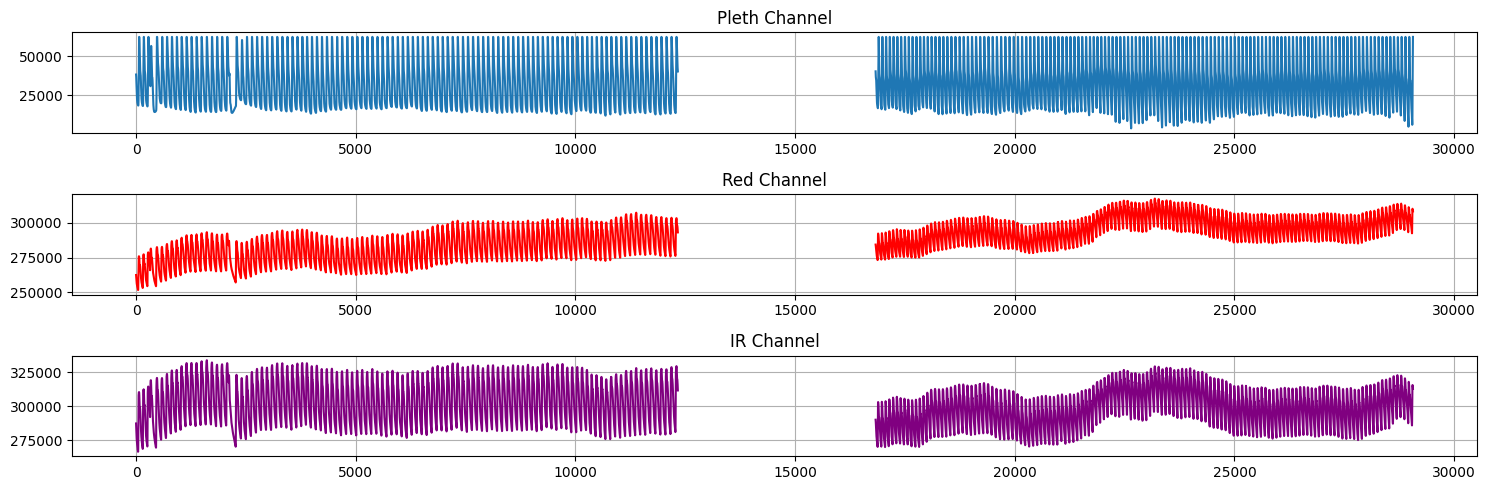

In [45]:
plt.figure(figsize=(15,5))

plt.subplot(3,1,1)
x = np.concatenate([ts1[DataColumn.PPG_CURVE][WavelengthIndex.PLETH], gap_data[0], ts2[DataColumn.PPG_CURVE][WavelengthIndex.PLETH]])
plt.plot(x)
plt.title('Pleth Channel')
plt.grid()

plt.subplot(3,1,2)
x = np.concatenate([ts1[DataColumn.PPG_CURVE][WavelengthIndex.RED], gap_data[0], ts2[DataColumn.PPG_CURVE][WavelengthIndex.RED]])
plt.plot(x, color='red')
plt.title('Red Channel')
plt.grid()

plt.subplot(3,1,3)
x = np.concatenate([ts1[DataColumn.PPG_CURVE][WavelengthIndex.IR], gap_data[0], ts2[DataColumn.PPG_CURVE][WavelengthIndex.IR]])
plt.plot(x, color='purple')
plt.title('IR Channel')
plt.grid()




plt.tight_layout()
plt.show()

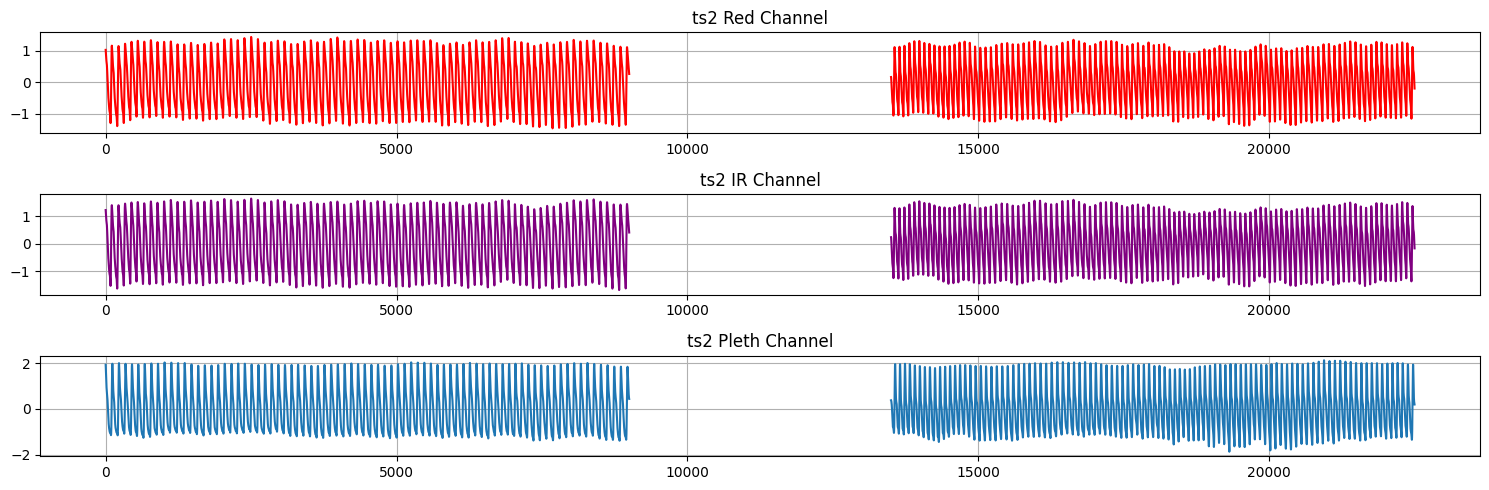

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(3,1,1)
plt.plot(ppg_data[WavelengthIndex.RED], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(ppg_data[WavelengthIndex.IR], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(ppg_data[WavelengthIndex.PLETH])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [12]:
data = ppg_data[WavelengthIndex.RED]

gap_indices = np.argwhere(np.isnan(data))
gap_start = gap_indices.min()
gap_end = gap_indices.max()

In [13]:
df = pd.DataFrame({'value': ppg_data[WavelengthIndex.RED]})

signal = ppg_data[WavelengthIndex.RED]
time = np.arange(0, len(signal)/1000, 0.01)
gap_signal = np.copy(signal)

gap_start = np.where(np.isnan(signal))[0][0]
gap_end = np.where(np.isnan(signal))[0][-1] + 1
gap_length = gap_end - gap_start
gap_size = gap_end-gap_start

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

In [15]:
segments = 2
# OVERLAP_SIZE = (gap_size // segments)
OVERLAP_SIZE = 0
SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / segments) + OVERLAP_SIZE)

_, _, Zxx_before = stft(gap_signal[:gap_start], fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, _, Zxx_after = stft(gap_signal[gap_end:], fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)

Zxx_gap = np.hstack([Zxx_before[:, -1:], Zxx_after[:, :1]])
# Zxx_before = np.hstack([Zxx_before, Zxx_before[:, -1:]])
# Zxx_after = np.hstack([Zxx_after[:, :1], Zxx_after[:, 1:2], Zxx_after[:, 2:]])

In [16]:
STRIP_SIZE = 5

t, x_gap_left = istft(Zxx_before[:, -1:], fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
t, x_gap_right = istft(Zxx_after[:, :1], fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)


x_gap_left = x_gap_left[STRIP_SIZE:-STRIP_SIZE]
x_gap_right = x_gap_right[STRIP_SIZE:-STRIP_SIZE]

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")


In [17]:
def _concatenate_time_series(s1: np.ndarray,
                             s2: np.ndarray,
                             precision: float = 0.01,
                             max_correlation_phase_shift: int = 200) -> np.ndarray:
    """
    Concatenate two time series by considering phase shift and derivation sign.
    Additional fine alignment is applied to smooth transitions between signals.
    """
    threshold = np.abs((max(s1) - min(s1)) * precision)
    alignment_value = s2[0]
    alignment_gradient_sign = np.sign(np.diff(s2[:2]))

    # shift = _get_phase_shift(s1, s2)
    # if np.abs(shift) < max_correlation_phase_shift:
    #     if shift < 0:
    #         s1 = s1[:shift]
    #     else:
    #         s2 = s2[shift:]

    fine_shift_index = 0
    for i, v in enumerate(reversed(s1)):
        difference = np.abs(alignment_value - v)
        actual_gradient_sign = np.sign(np.diff(s1[-i-2:-i]))
        if difference <= threshold and alignment_gradient_sign == actual_gradient_sign:
            fine_shift_index = i
            break

    return np.concatenate([s1[:len(s1)-fine_shift_index], s2])

In [18]:
segments = 10
OVERLAP_SIZE = (gap_size // segments)
SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / segments) + OVERLAP_SIZE)

x = _concatenate_time_series(gap_signal[:gap_start], x_gap_left, precision=0.01)
x = _concatenate_time_series(x , x_gap_right, precision=0.01)
x = _concatenate_time_series(x, gap_signal[gap_end:], precision=0.01)

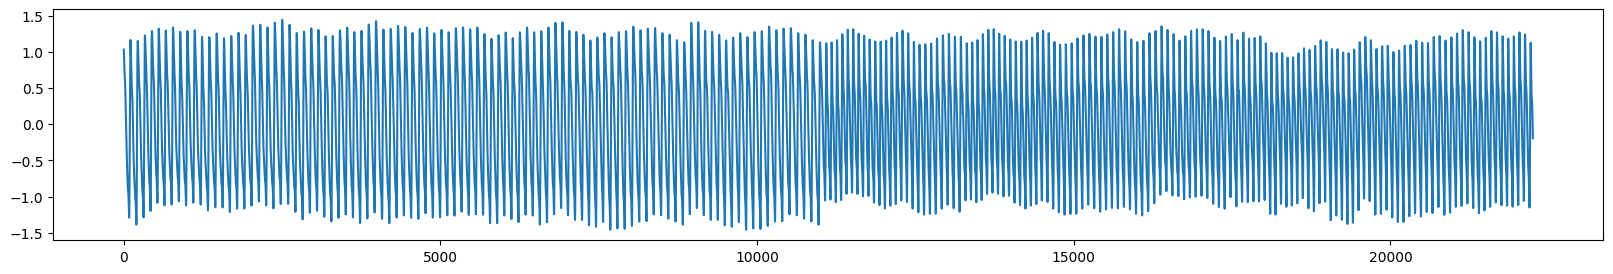

In [19]:
plt.figure(figsize=(20,3))
plt.plot(x)

In [20]:
frequencies, times, Zxx = stft(x, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


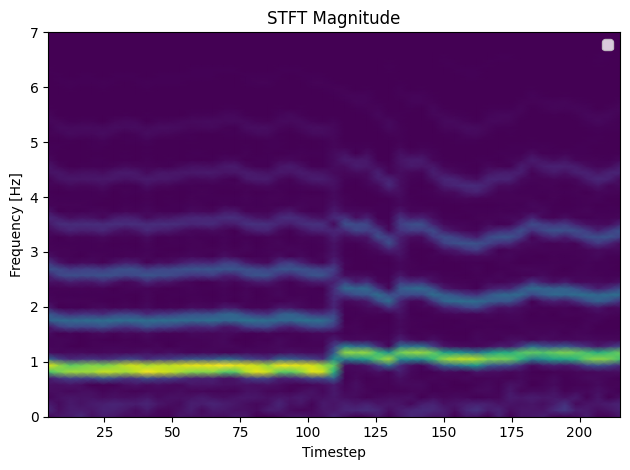

In [21]:
fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [22]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

def create_lags(data, n_lags):
    df = pd.DataFrame(data)
    columns = [df]
    for i in range(1, n_lags+1):
        columns.append(df.shift(i))
    lagged_data = pd.concat(columns, axis=1)
    lagged_data.columns = ['lag_'+str(i) for i in range(n_lags+1)]
    lagged_data = lagged_data.dropna()
    return lagged_data


n_lags = 50

# df = pd.DataFrame({'value': gap_signal})

data_before_gap = x[:gap_start]
data_after_gap = x[gap_end+1:]
data_gap = x[gap_start:gap_end+1]

# Split the lagged data into pre-gap, gap, and post-gap data
pre_gap_data = create_lags(data_before_gap[-4000:], n_lags)
post_gap_data = create_lags(data_after_gap[:4000], n_lags)


# Prepare the Random Forest models
rf_pre_gap = RandomForestRegressor(n_estimators=100, random_state=0)
rf_post_gap = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the models
rf_pre_gap.fit(pre_gap_data.drop('lag_0', axis=1), pre_gap_data['lag_0'])
rf_post_gap.fit(post_gap_data.drop('lag_0', axis=1), post_gap_data['lag_0'])


RandomForestRegressor(random_state=0)

In [23]:
data_before_gap[-n_lags:]

array([0.54769877, 0.73170556, 0.89590701, 1.03723296, 1.15404499,
       1.24610002, 1.31440209, 1.36096641, 1.38852657, 1.40021876,
       1.39927554, 1.38875778, 1.37134607, 1.34920469, 1.32392234,
       1.29652505, 1.26754985, 1.23716214, 1.20529688, 1.17180325,
       1.1365741 , 1.09964537, 1.06125595, 1.02186416, 0.98212303,
       0.94282159, 0.90480298, 0.86887235, 0.83570749, 0.8057837 ,
       0.77932145, 0.75626195, 0.73627176, 0.71877405, 0.70300135,
       0.68806274, 0.67301748, 0.6569476 , 0.63902256, 0.61855104,
       0.59501685, 0.56809766, 0.53766741, 0.50378441, 0.4666684 ,
       0.42667004, 0.38423668, 0.33987754, 0.29413112, 0.24753671])

In [24]:
data_gap = np.concatenate([data_before_gap[-n_lags:], x[gap_start:gap_end+1]])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


for i in range(5):
    test_gap_data = create_lags(data_gap, n_lags)

    prediction_before = rf_pre_gap.predict(test_gap_data.drop('lag_0', axis=1))
    prediction_after = rf_post_gap.predict(test_gap_data.drop('lag_0', axis=1))

    weights = np.linspace(0, 1, len(prediction_before))
    # weights = sigmoid(np.linspace(-6, 6, len(prediction_before)))
    # weight = 1 - i/gap_size
    # prediction = weight*prediction_before + (1-weight)*prediction_after
    prediction = prediction_before * (1 - weights) + prediction_after * weights

    data_gap = np.concatenate([data_before_gap[-n_lags:], prediction])

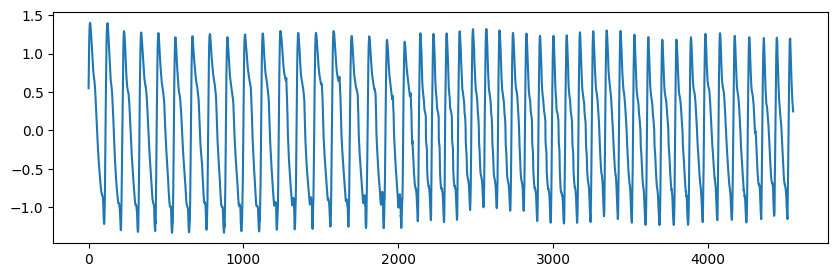

In [25]:
plt.figure(figsize=(10,3))
# plt.plot(x[gap_start:gap_end+1])
plt.plot(data_gap)

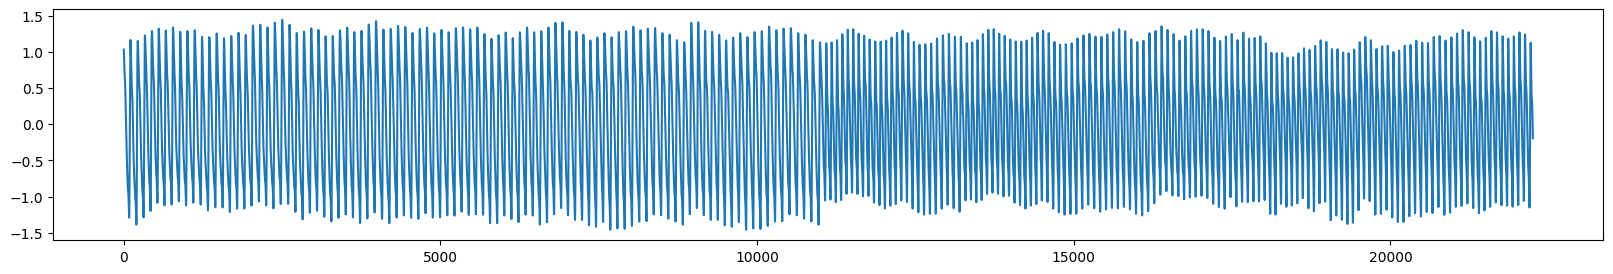

In [26]:
plt.figure(figsize=(20,3))
# plt.plot(x[gap_start:gap_end+1])
plt.plot(np.concatenate([data_before_gap, x[gap_start:gap_end+1], data_after_gap]))

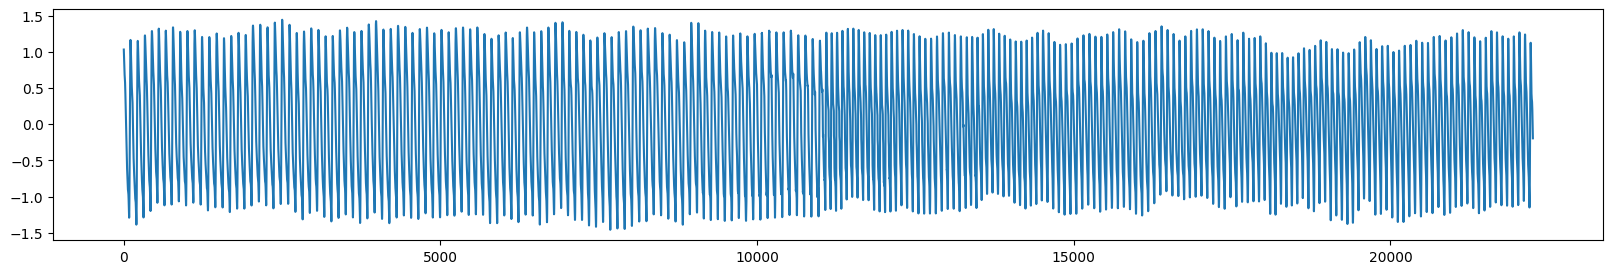

In [27]:
plt.figure(figsize=(20,3))
plt.plot(np.concatenate([data_before_gap, prediction, data_after_gap]))

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


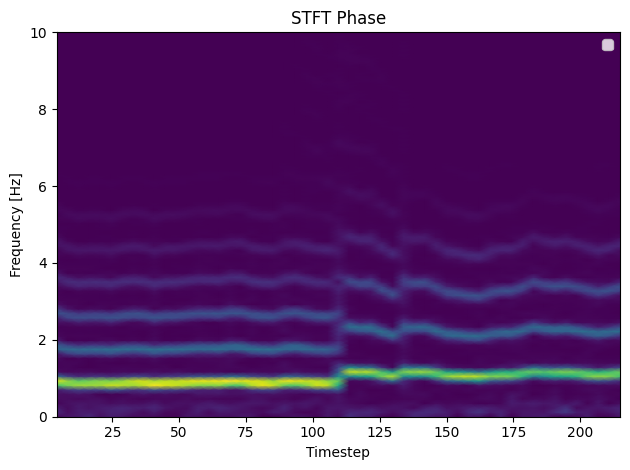

In [28]:
frequencies, times, complex_data = stft(np.concatenate([data_before_gap, prediction, data_after_gap]), fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, reconstructed_signal = istft(complex_data, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 10])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

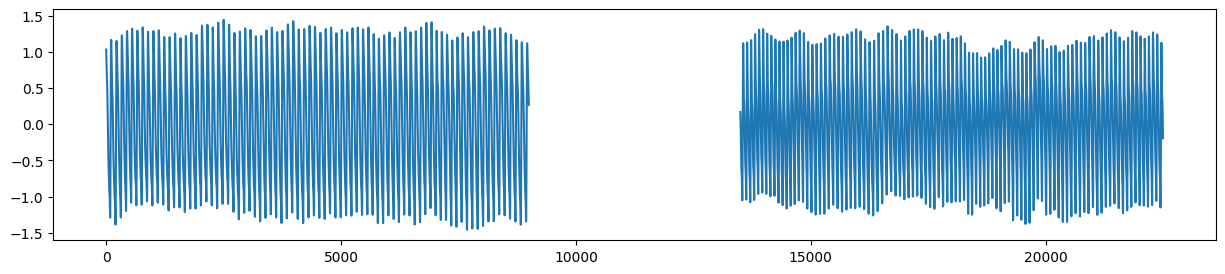

In [29]:
plt.figure(figsize=(15,3))
plt.plot(gap_signal)

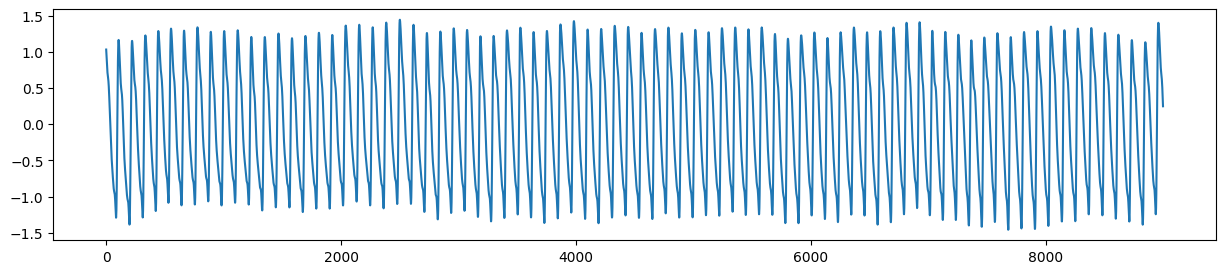

In [30]:
plt.figure(figsize=(15,3))
plt.plot(data_before_gap)

In [31]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import UnivariateSpline


plt.figure(figsize=(20,3))
# Determine the indices of the local maxima and minima

maxima, _ = find_peaks(data_after_gap, distance=50)
minima, _ = find_peaks(-data_after_gap, distance=50)

upper_spline = UnivariateSpline(maxima, data_after_gap[maxima], s=0)
lower_spline = UnivariateSpline(minima, data_after_gap[minima], s=0)

x_range = np.arange(len(data_after_gap))

maxima

array([  63,  149,  235,  321,  408,  495,  582,  669,  755,  840,  926,
       1014, 1103, 1193, 1282, 1373, 1465, 1558, 1652, 1746, 1841, 1935,
       2028, 2121, 2215, 2310, 2405, 2501, 2598, 2693, 2789, 2885, 2980,
       3075, 3168, 3260, 3351, 3443, 3535, 3626, 3719, 3810, 3901, 3993,
       4085, 4175, 4266, 4355, 4443, 4531, 4619, 4704, 4789, 4875, 4961,
       5047, 5134, 5222, 5310, 5398, 5486, 5575, 5663, 5751, 5839, 5926,
       6014, 6101, 6190, 6279, 6368, 6457, 6546, 6635, 6725, 6816, 6907,
       7000, 7091, 7183, 7276, 7369, 7460, 7550, 7641, 7733, 7825, 7915,
       8004, 8092, 8181, 8270, 8359, 8447, 8535, 8624, 8713], dtype=int64)

<Figure size 2000x300 with 0 Axes>

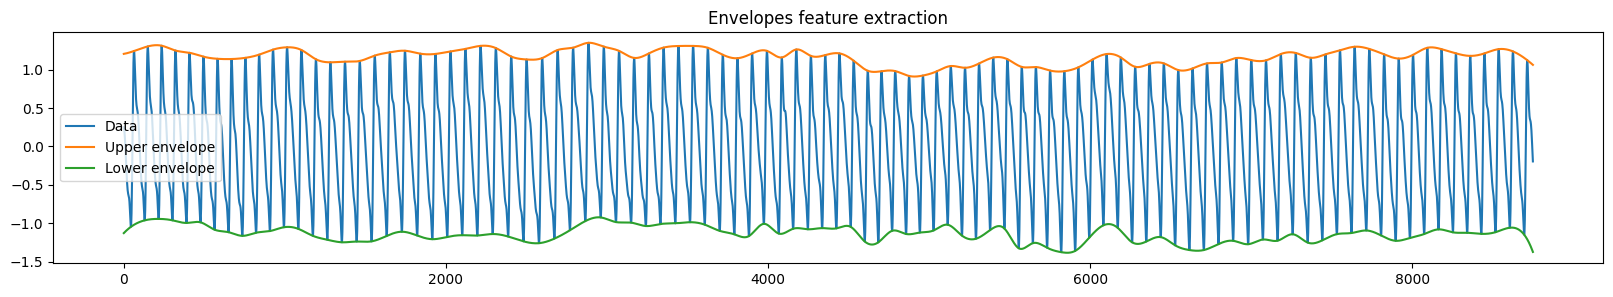

In [32]:
plt.figure(figsize=(20,3))
plt.plot(data_after_gap, label='Data')

plt.plot(upper_spline(x_range), label='Upper envelope')

plt.plot(pd.DataFrame(lower_spline(x_range)), label='Lower envelope')
plt.title('Envelopes feature extraction')
plt.legend()
# lower_spline(minima).shape

In [33]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import UnivariateSpline

def create_lag_metrics(data, n_lags, rolling_windows, shuffle=False):
    df = pd.DataFrame({'lag_0': data})

    for i in range(1, n_lags+1):
        df[f'lag_{i}'] = df['lag_0'].shift(i)

    for w in rolling_windows or []:
        df[f'rolling_std_{w}'] = df['lag_1'].rolling(window=w, min_periods=min([n_lags*10, min(rolling_windows)])).std()
        df[f'rolling_mean_{w}'] = df['lag_1'].rolling(window=w, min_periods=min([n_lags*10, min(rolling_windows)])).mean()

    df = df.dropna()

    envelope_maxima, _ = find_peaks(df['lag_1'].values, distance=50)
    envelope_minima, _ = find_peaks(-df['lag_1'].values, distance=50)

    upper_spline = UnivariateSpline(envelope_maxima, df['lag_1'].values[envelope_maxima], s=0)
    lower_spline = UnivariateSpline(envelope_minima, df['lag_1'].values[envelope_minima], s=0)
    x_range = np.arange(len(df['lag_1']))

    df['lower_envelope_spline'] = lower_spline(x_range)
    df['upper_envelope_spline'] = upper_spline(x_range)
    df['lower_envelope_spline_diff'] = df['lower_envelope_spline'].diff()
    df['upper_envelope_spline_diff'] = df['upper_envelope_spline'].diff()

    del df['lower_envelope_spline']
    del df['upper_envelope_spline']

    df_upper = pd.DataFrame({'last_upper_envelope': df['lag_1'].values[envelope_maxima]})
    df_upper['last_upper_envelope_diff'] = df_upper['last_upper_envelope'].diff()
    df_upper.index = envelope_maxima
    df = pd.concat([df, df_upper], axis=1).fillna(method='ffill').bfill()

    df_lower = pd.DataFrame({'last_lower_envelope': df['lag_1'].values[envelope_minima]})
    df_lower['last_lower_envelope_diff'] = df_lower['last_lower_envelope'].diff()
    df_lower.index = envelope_minima
    df = pd.concat([df, df_lower], axis=1).fillna(method='ffill').bfill()

    if shuffle:
        df = df.sample(frac=1)

    y = df['lag_0']
    X = df.drop('lag_0', axis=1)

    return X, y

In [34]:
N_LAGS = 20
ROLLING_WINDOWS = [50, 150, 700,2000]


x_before,y_before = create_lag_metrics(data_before_gap, n_lags=N_LAGS, rolling_windows=ROLLING_WINDOWS)
x_after,y_after = create_lag_metrics(data_after_gap, n_lags=N_LAGS, rolling_windows=ROLLING_WINDOWS)

In [48]:
x_before

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,rolling_std_700,rolling_mean_700,rolling_std_2000,rolling_mean_2000,lower_envelope_spline_diff,upper_envelope_spline_diff,last_upper_envelope,last_upper_envelope_diff,last_lower_envelope,last_lower_envelope_diff
50,-0.542335,-0.515913,-0.488388,-0.459569,-0.429302,-0.397469,-0.363998,-0.328854,-0.292036,-0.253577,...,0.481687,0.311086,0.481687,0.311086,-0.003986,-0.002006,1.163761,-0.01337,-1.386800,-0.095716
51,-0.567871,-0.542335,-0.515913,-0.488388,-0.459569,-0.429302,-0.397469,-0.363998,-0.328854,-0.292036,...,0.492474,0.293852,0.492474,0.293852,-0.003986,-0.002006,1.163761,-0.01337,-1.386800,-0.095716
52,-0.592752,-0.567871,-0.542335,-0.515913,-0.488388,-0.459569,-0.429302,-0.397469,-0.363998,-0.328854,...,0.502883,0.276802,0.502883,0.276802,-0.003941,-0.001984,1.163761,-0.01337,-1.386800,-0.095716
53,-0.617209,-0.592752,-0.567871,-0.542335,-0.515913,-0.488388,-0.459569,-0.429302,-0.397469,-0.363998,...,0.512941,0.259933,0.512941,0.259933,-0.003897,-0.001962,1.163761,-0.01337,-1.386800,-0.095716
54,-0.641449,-0.617209,-0.592752,-0.567871,-0.542335,-0.515913,-0.488388,-0.459569,-0.429302,-0.397469,...,0.522676,0.243241,0.522676,0.243241,-0.003853,-0.001940,1.163761,-0.01337,-1.386800,-0.095716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,0.426670,0.466668,0.503784,0.537667,0.568098,0.595017,0.618551,0.639023,0.656948,0.673017,...,0.815164,0.008430,0.837848,-0.012061,0.005132,0.006372,1.400219,0.26915,-1.243844,0.143888
8997,0.384237,0.426670,0.466668,0.503784,0.537667,0.568098,0.595017,0.618551,0.639023,0.656948,...,0.814762,0.007861,0.837658,-0.011417,0.005176,0.006425,1.400219,0.26915,-1.243844,0.143888
8998,0.339878,0.384237,0.426670,0.466668,0.503784,0.537667,0.568098,0.595017,0.618551,0.639023,...,0.814352,0.007251,0.837452,-0.010791,0.005221,0.006479,1.400219,0.26915,-1.243844,0.143888
8999,0.294131,0.339878,0.384237,0.426670,0.466668,0.503784,0.537667,0.568098,0.595017,0.618551,...,0.813935,0.006594,0.837233,-0.010184,0.005266,0.006533,1.400219,0.26915,-1.243844,0.143888


In [35]:
from sklearn.model_selection import train_test_split

X_before_train, X_before_test, y_before_train, y_before_test = train_test_split(x_before, y_before, test_size=0.2, random_state=42)
X_after_train, X_after_test, y_after_train, y_after_test = train_test_split(x_after, y_after, test_size=0.2, random_state=42)

In [36]:
rf_pre_gap = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=6)
rf_post_gap = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=6)

# Fit the models
rf_pre_gap.fit(X_before_train, y_before_train)
rf_post_gap.fit(X_after_train, y_after_train)

RandomForestRegressor(n_estimators=150, n_jobs=6, random_state=0)

In [37]:
from sklearn import metrics


pred = rf_pre_gap.predict(X_before_test)
gt = y_before_test
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 0.003949636796106435
Mean Squared Error (MSE): 3.3716995225680865e-05
Root Mean Squared Error (RMSE): 0.005806633725807136
Mean Absolute Percentage Error (MAPE): 1.63
Accuracy: 98.37


In [38]:
pred = rf_post_gap.predict(X_after_test)
gt = y_after_test
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 0.00532252791918039
Mean Squared Error (MSE): 5.7874891967066236e-05
Root Mean Squared Error (RMSE): 0.0076075549269831915
Mean Absolute Percentage Error (MAPE): 3.13
Accuracy: 96.87


In [39]:
x_circular = data_before_gap[-max(ROLLING_WINDOWS + [N_LAGS]) - 1:]
x_win,_  = create_lag_metrics(np.append(x_circular, [80]), n_lags=N_LAGS, rolling_windows=ROLLING_WINDOWS)

x_win.tail(1)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,rolling_std_700,rolling_mean_700,rolling_std_2000,rolling_mean_2000,lower_envelope_spline_diff,upper_envelope_spline_diff,last_upper_envelope,last_upper_envelope_diff,last_lower_envelope,last_lower_envelope_diff
2001,0.247537,0.294131,0.339878,0.384237,0.42667,0.466668,0.503784,0.537667,0.568098,0.595017,...,0.813511,0.005889,0.837003,-0.009599,0.005312,0.006587,1.400219,0.26915,-1.243844,0.143888


In [40]:
x_circular = data_before_gap[-max(ROLLING_WINDOWS + [N_LAGS]) - 1:]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

weights = sigmoid(np.linspace(-4, 4, gap_size))

predictions = []
for i in range(gap_size):
    x_win,_  = create_lag_metrics(np.append(x_circular, [80]), n_lags=N_LAGS, rolling_windows=ROLLING_WINDOWS)
    x_win = x_win.tail(1)

    prediction_before = rf_pre_gap.predict(x_win)[0]
    prediction_after = rf_post_gap.predict(x_win)[0]

    # weight = 1 - i/gap_size
    weight = 1 - weights[i]
    prediction = weight*prediction_before + (1-weight)*prediction_after

    # prediction = prediction_before
    x_circular = np.append(x_circular, [prediction])[1:]
    predictions.append(prediction)

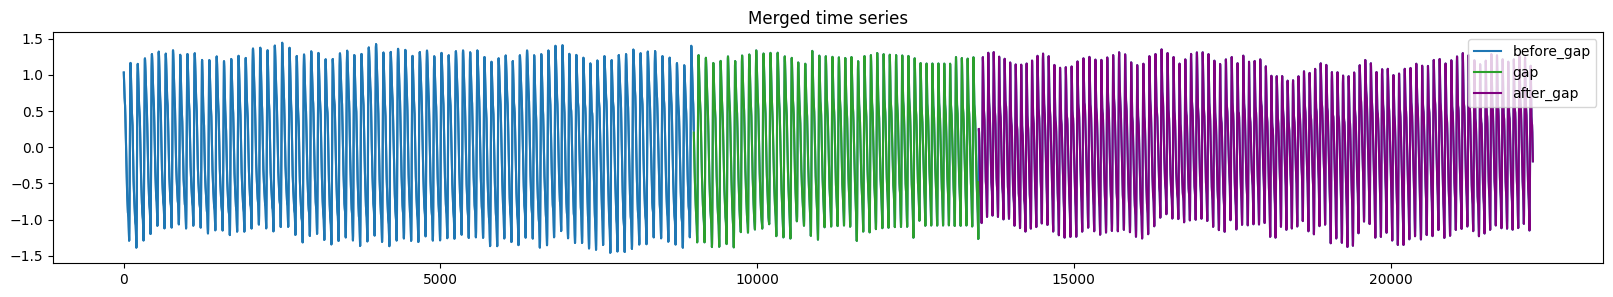

In [47]:
plt.figure(figsize=(20,3))
# plt.plot(predictions)
plt.plot(np.concatenate([data_before_gap, predictions, data_after_gap]))

plt.plot(data_before_gap, label='before_gap', color='tab:blue')
plt.plot(np.arange(gap_start, gap_end), predictions, label='gap', color='tab:green')
plt.plot(np.arange(gap_end, gap_end+len(data_after_gap)), data_after_gap, label='after_gap', color='purple')
plt.title('Merged time series')
plt.legend()

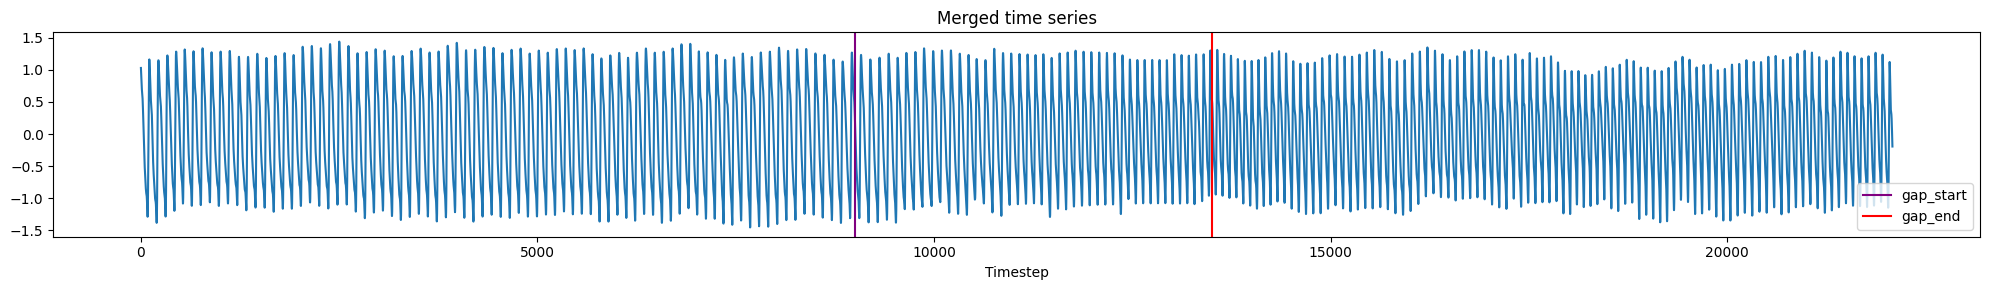

In [42]:
x = _concatenate_time_series(data_before_gap, predictions, precision=0.01)
x = _concatenate_time_series(x, data_after_gap, precision=0.01)

plt.figure(figsize=(20,3))
plt.plot(x)
plt.title('Merged time series')
plt.axvline(x=gap_start, label='gap_start', color='purple')
plt.axvline(x=gap_end, label='gap_end', color='red')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()

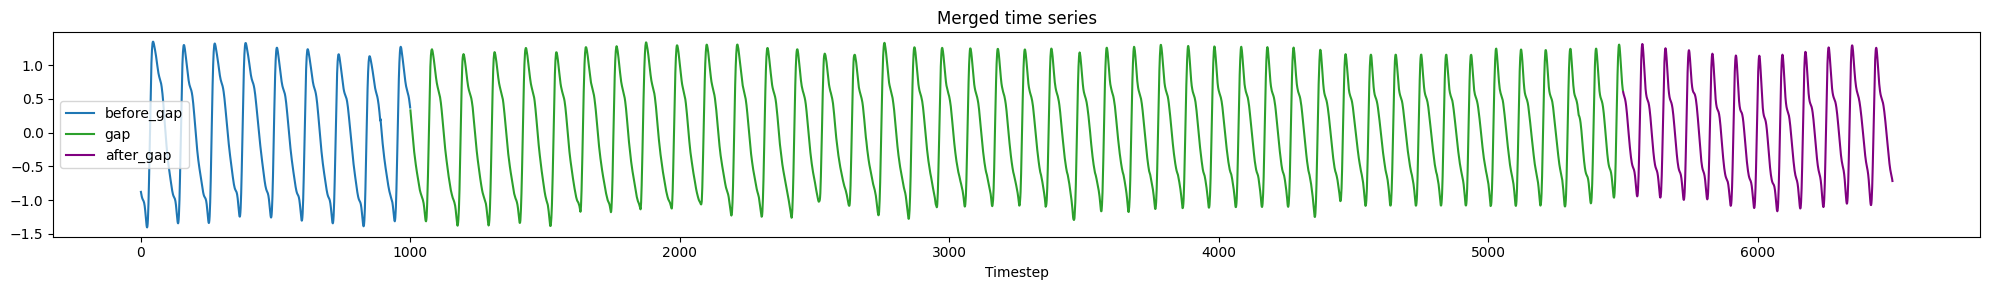

In [43]:
CHUNK_SIZE = 1000
x = _concatenate_time_series(data_before_gap, predictions, precision=0.01)
x = _concatenate_time_series(x, data_after_gap, precision=0.01)

plt.figure(figsize=(20,3))
plt.plot(x[gap_start-CHUNK_SIZE:gap_start], label='before_gap', color='tab:blue')
plt.plot(np.arange(CHUNK_SIZE, CHUNK_SIZE+gap_size), x[gap_start:gap_end], label='gap', color='tab:green')
plt.plot(np.arange(CHUNK_SIZE+gap_size, CHUNK_SIZE+gap_size+CHUNK_SIZE), x[gap_end:gap_end+CHUNK_SIZE], label='after_gap', color='purple')


plt.title('Merged time series')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()

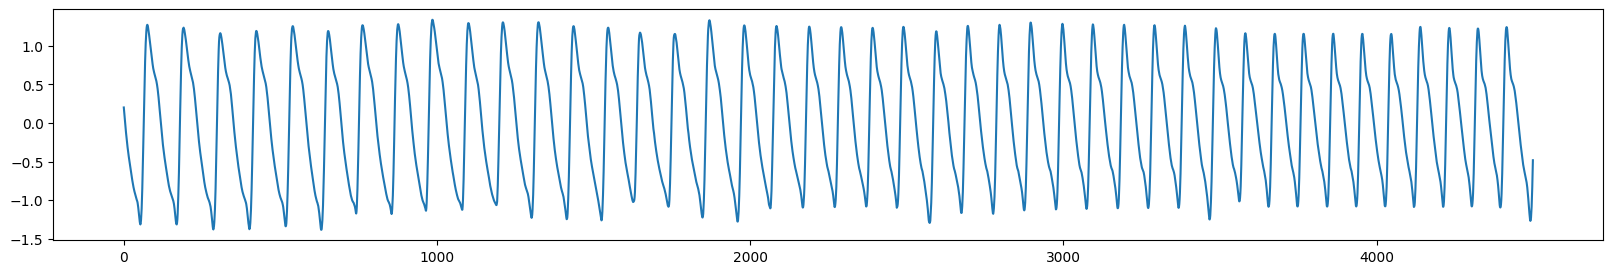

In [44]:
plt.figure(figsize=(20,3))
plt.plot(predictions)

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")


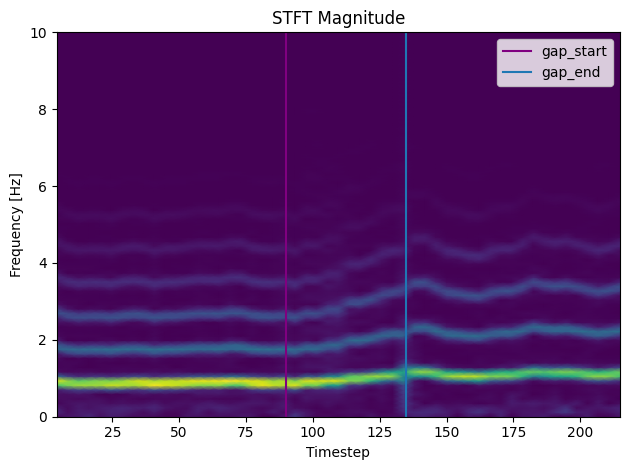

In [45]:
frequencies, times, complex_data = stft(np.concatenate([data_before_gap, predictions, data_after_gap]), fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, reconstructed_signal = istft(complex_data, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 10])
plt.axvline(x=gap_start/100, label='gap_start', color='purple')
plt.axvline(x=gap_end/100, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()